At this point just playing around with feature engineering. Need to resample.  Should try upsampling and downsampling

In [ ]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from ggplot import *
import time
import seaborn as sns

In [2]:
data_path = '../../data'
loans_full = pd.read_csv(data_path+"/loans_full.zip", index_col=0)
loans_details = pd.read_csv(data_path+"/loans_details.zip", index_col=0)
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (21,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/j/virtualenvs/delta/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (8,9,10,29,42,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['expired'] = df['status']=='expired'
df = df[df['status']!='fundraising']

In [4]:
loans_full['status'].value_counts()

funded         122273
expired          4683
fundraising       944
Name: status, dtype: int64

In [5]:
df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
df['num_borrowers'] = df['borrowers'].apply(lambda x: len([y for y in x if y=='}']))
# convert strs to datetimes
for col in df.columns:
    if "_date" in col:
        df[col] = pd.to_datetime(df[col])
        col_root = col.split('_date')[0]
        df[col_root+"_year"] = df[col].apply(lambda x: x.year)
        df[col_root+"_month"] = df[col].apply(lambda x: x.month)
        df[col_root+"_unix"] = df[col].apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)
        

In [6]:
df['lat'] = df['location.geo.pairs'].apply(lambda x: x.split()[0])
df['long'] = df['location.geo.pairs'].apply(lambda x: x.split()[1])

In [7]:
df['motor'] = df['use'].apply(lambda x: 1 if type(x)==str and 'motor' in x.lower() else 0)
df['more'] = df['use'].apply(lambda x: 1 if type(x)==str and 'more' in x.lower() else 0)
df['solar'] = df['use'].apply(lambda x: 1 if type(x)==str and 'to purchase a solar light ' in x.lower() else 0)

In [9]:
num_posted = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).count()['activity'])
num_posted.columns = ['num_posted']
num_expired = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).count()['activity'])
num_expired.columns = ['num_expired']
mean_loan = pd.DataFrame(df.groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_loan.columns = ['mean_loan']
mean_expired_loan = pd.DataFrame(df[df['status']=='expired'].groupby(['posted_month', 'posted_year']).mean()['loan_amount'])
mean_expired_loan.columns = ['mean_expired_loan']
df = df.merge(num_posted, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(num_expired, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df = df.merge(mean_expired_loan, left_on=['posted_month', 'posted_year'], right_index=True, how='outer')
df['relative_loan'] = df['loan_amount'] / df['mean_loan']

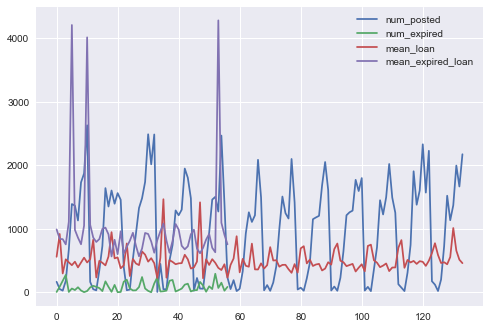

In [10]:
# need to fix plot, time axis is incorrect
plt.plot(num_posted['num_posted'].values, label='num_posted')
plt.plot(num_expired['num_expired'].values, label='num_expired')
plt.plot(mean_loan['mean_loan'].values, label='mean_loan')
plt.plot(mean_expired_loan['mean_expired_loan'].values, label='mean_expired_loan')
plt.legend()
plt.show()

In [11]:
X = df[['expired','relative_loan', 'mean_loan','num_posted','more','motor','solar','lat','long','posted_unix','num_borrowers','male', 'activity', 'location.town', 'partner_id', "sector", "tags", "loan_amount"]]
rf_X = X.copy()
rf_X = rf_X.dropna()
y = rf_X['expired']
rf_X = rf_X.drop("expired", axis=1)
rf_X.columns

for col in X.columns[1:]:
    if col not in ['male','relative_loan', 'mean_loan','num_posted', 'more','motor','solar','loan_amount','num_borrowers', 'funded_unix','lat','long', 'lender_count']:
        if col=='tags':
            col_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
        else:
            col_vals = X[col].value_counts().index[:10]
            
        for col_val in col_vals:
            if col_val not in rf_X.columns:
                rf_X[col+"_"+str(col_val)] = X[col]==col_val
            else:
                print(col, col_val)
        rf_X = rf_X.drop(col, axis=1)
    else:
        pass
    
rf = RandomForestClassifier(n_estimators=100, oob_score=True)
rf.fit(rf_X,y)
rf.oob_score_

0.95697176214794044

In [12]:
# Print Feature importances.
# Results show that time trends are the most important, followed by amount funded. Very Strange that month makes the list
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, rf_X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. feature relative_loan (0.207928)
2. feature loan_amount (0.164654)
3. feature num_posted (0.129626)
4. feature mean_loan (0.118007)
5. feature num_borrowers (0.051127)
6. feature male (0.047547)
7. feature long (0.034313)
8. feature lat (0.034051)
9. feature more (0.016249)
10. feature partner_id_138.0 (0.011839)
11. feature partner_id_386.0 (0.011499)
12. feature sector_Retail (0.011057)
13. feature sector_Food (0.008855)
14. feature activity_Farming (0.008527)
15. feature activity_General Store (0.008126)
16. feature partner_id_133.0 (0.007912)
17. feature activity_Retail (0.007667)
18. feature motor (0.007376)


In [13]:
df.columns

Index(['activity', 'basket_amount', 'bonus_credit_eligibility', 'borrowers',
       'currency_exchange_loss_amount', 'description.languages',
       'description.texts.en', 'description.texts.es', 'description.texts.fr',
       'description.texts.ru', 'funded_amount', 'funded_date', 'id',
       'image.id', 'image.template_id', 'journal_totals.bulkEntries',
       'journal_totals.entries', 'lender_count', 'loan_amount',
       'location.country', 'location.country_code', 'location.geo.level',
       'location.geo.pairs', 'location.geo.type', 'location.town', 'name',
       'partner_id', 'payments', 'planned_expiration_date', 'posted_date',
       'sector', 'status', 'tags', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.local_payments', 'terms.loss_liability.currency_exchange',
       'terms.loss_liability.currency_exchange_coverage_rate',
       'terms.loss_liability.nonpayment', 'terms.repayment_interval',
     

In [14]:
df[df['status']=='expired']['sector'].value_counts()

Agriculture       2040
Retail            1066
Food               644
Transportation     375
Clothing           311
Services           204
Housing             20
Education           14
Construction         5
Personal Use         4
Name: sector, dtype: int64

In [15]:
df['sector'].value_counts()

Agriculture       46938
Food              26439
Retail            19620
Services          10922
Clothing           9159
Transportation     3825
Personal Use       2363
Construction       1895
Education          1830
Health             1314
Manufacturing       887
Housing             799
Arts                754
Entertainment       136
Wholesale           133
Name: sector, dtype: int64

In [16]:
num_expired

num_expired
posted_month posted_year             
1            2014                   5
             2015                  88
             2016                 181
             2017                 273
2            2012                   5
             2014                  59
             2015                  35
             2016                  79
             2017                  28
3            2012                   2
             2014                  20
             2015                  77
             2016                 101
             2017                  86
4            2012                  66
             2014                  19
             2015                 172
             2016                  85
             2017                   7
5            2012                 116
             2013                   1
             2014                   5
             2015                 166
             2016                 198
6            2012                  60
             2013                  29
             2014                  31
             2015                  82
             2016                 240
7            2012                  59
             2013                  22
             2014                   1
             2015                 139
             2016                 235
8            2012                  12
             2013                  16
             2014                  26
             2015                 181
             2016                 194
9            2012                  12
             2013                  34
             2014                  58
             2015                 120
             2016                 135
10           2012                  13
             2013                  32
             2014                  34
             2015                 163
             2016                 106
11           2012                   9
             2014                  94
             2015                  51
             2016                 292
12           2013                  68
             2014                 151
             2015                  25
             2016                  85

In [17]:
df[(df['posted_month']==11)&(df['posted_year']==2016)&(df['status']=='expired')]['solar'].sum()

10

In [18]:
df[(df['posted_month']==11)&(df['posted_year']==2016)]['use']

11404    to purchase a solar light and gain access to c...
11405    to purchase a solar light and gain access to c...
11406    to purchase a solar light and gain access to c...
11407    to purchase a solar light and gain access to c...
11408    to buy farm inputs such as good-quality seeds,...
11409    to buy farm implements, high-quality seeds, go...
11410                        to build a modern dairy shed.
11411                                      to buy cereals.
11412    to buy more stock of sugar, soap, flour, cooki...
11413                            to buy cereals to resell.
11414                                      to buy cereals.
11415                                  to buy animal feed.
11416    to buy more stock of cables, radio, speakers a...
11417    to buy cost-efficient maize seeds and fertiliz...
11418         to buy materials for making school uniforms.
11419            to add stock of maize, beans, and fruits.
11420                    for adding stock of pork to sel

In [ ]:
df.columns